In [1]:
!nvidia-smi

Sun Oct 20 22:15:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/yelp_reviews_subset_2.csv')
print(df)


     Unnamed: 0                                               Text  Labels
0             0  My expectations for McDonalds are t rarely hig...       0
1             1  I've tried to give this McDonalds a chance but...       0
2             2  This McDonald's is so bad it's amazing.  \n\nO...       0
3             3  We had the worst possible experience at the Ea...       0
4             4  They burned my fish and they burned it bad.  O...       2
..          ...                                                ...     ...
495         495  This place is PHENOMENAL.\nI got my bunny here...       4
496         496  This is a bizarre CVS, the kind you would only...       1
497         497  I go to this CVS all the time, since I work in...       1
498         498  Never again. Let me repeat, never again. \n\nT...       0
499         499  The times I've been here, its been an OK exper...       1

[500 rows x 3 columns]


<ipython-input-5-9f4476d016dd>:14: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


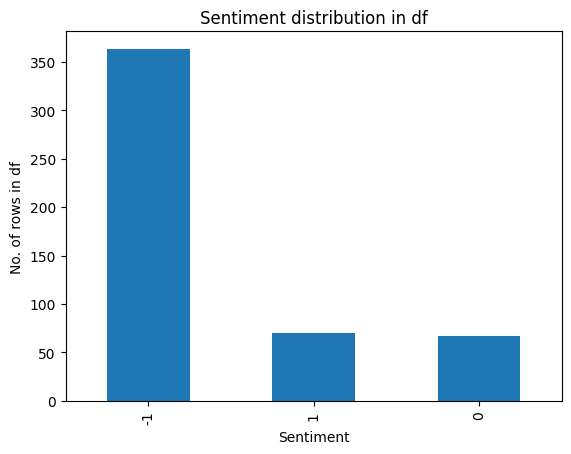

In [5]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1


# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['Labels']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Device: GPU ({torch.cuda.get_device_name(0)})")
else:
    device = torch.device("cpu")
    print("Device: CPU")

print("Using device:", device)


Device: GPU (Tesla T4)
Using device: cuda


In [28]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()

        # TODO: Add an fc1 layer as described below
        # Linear function 1: vocab_size --> hiiden_dim
        self.fc1 = nn.Linear(input_dim , hidden_dim)

        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # TODO: Add an fc2 layer as described below
        # Linear function 2: hidden_dim --> hidden_dim
        self.fc2 = nn.Linear(hidden_dim , hidden_dim)

        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # TODO: Add an fc3 layer as described below
        # Linear function 3 (readout): hidden_dim --> output_dim
        self.fc3 = nn.Linear(hidden_dim , output_dim)

    def forward(self, x):

        # TODO: Forward pass through fully connected layer 1
        out = self.fc1(x)

        # Non-linearity 1
        out = self.relu1(out)

        # TODO: Forward pass through fully connected layer 2
        out = self.fc2(out)

        # Non-linearity 2
        out = self.relu2(out)

        # TODO: Forward pass through fully connected layer 3
        out = self.fc3(out)

        return F.softmax(out, dim=1)

In [29]:
# TODO: Tokenize each sentence into word tokens and store them as a list in the dataframe
# Use List Comprehension
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df['tokenized_text'] = [word_tokenize(x) for x in df['Text']]
print(df['tokenized_text'].head(10))

ps = PorterStemmer()
# TODO: Use the Porter Stemmer to find stem words of each word for all the words in df["tokenized_text"]
# Hint: Use List Comprehension
df['stemmed_tokens'] = [[ps.stem(word) for word in tokens]  # Iterate over each word in the token list
    for tokens in df["tokenized_text"]
]
df['stemmed_tokens'].head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [My, expectations, for, McDonalds, are, t, rar...
1    [I, 've, tried, to, give, this, McDonalds, a, ...
2    [This, McDonald, 's, is, so, bad, it, 's, amaz...
3    [We, had, the, worst, possible, experience, at...
4    [They, burned, my, fish, and, they, burned, it...
5    [Some, how, even, though, the, food, at, this,...
6    [Mmm, ..., peppermint, mocha\n\nIn, my, quest,...
7    [If, there, was, ever, a, \, '', get, your, co...
8    [I, just, realized, they, remodeled, this, one...
9    [Great, location, !, Close, to, shops, and, th...
Name: tokenized_text, dtype: object


,stemmed_tokens
0,"[my, expect, for, mcdonald, are, t, rare, high..."
1,"[i, 've, tri, to, give, thi, mcdonald, a, chan..."
2,"[thi, mcdonald, 's, is, so, bad, it, 's, amaz,..."
3,"[we, had, the, worst, possibl, experi, at, the..."
4,"[they, burn, my, fish, and, they, burn, it, ba..."
5,"[some, how, even, though, the, food, at, thi, ..."
6,"[mmm, ..., peppermint, mocha\n\nin, my, quest,..."
7,"[if, there, wa, ever, a, \, '', get, your, cof..."
8,"[i, just, realiz, they, remodel, thi, one, rec..."
9,"[great, locat, !, close, to, shop, and, theatr..."


In [30]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]],
                                                        df['sentiment'],
                                                        shuffle=shuffle_state,
                                                        test_size=test_size,
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
-1    255
 1     49
 0     46
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
-1    108
 1     21
 0     21
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index                                               Text  Labels  \
0    139  The food is standard American fare--a bit over...       1   
1    129  I'm not much of a beer drinker, but my fiancee...       3   
2    258  ok so i've eaten here more than once but just ...       1   
3    227  Food was ok had a steak w/ shrimp side Ass mas...       1   
4     60  He was incredibly sexist/homophobic. He could ...       0   

                                      tokenized_text  \
0  [The, food, is, standard, American, fare, --, ...   
1  [I, 'm, not, much, of, a, beer, drinker, ,, bu...   
2  [ok, so, i, 've, eaten, here, more, than, once...   
3  [Food, was, ok, had, a, steak, w/, shrimp, sid...   
4  [He, was, incredi

In [31]:
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

# Make the dictionary without padding for the basic models
review_dict = make_dict(df, padding=False)

Dictionary without padding


In [32]:
VOCAB_SIZE = 30056
NUM_LABELS = 3

# Function to make bow vector to be used as input to network
def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [33]:
VOCAB_SIZE = len(review_dict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

# TODO: Call the FeedForwardNeuralNetwork Class object with appropriate arguements
ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

# TODO: Move the model to device
ff_nn_bow_model = ff_nn_bow_model.to(device)

# TODO: Define the loss function as Cross Entropy Loss
loss_function = nn.CrossEntropyLoss()

# TODO: Define a Stochastic Gradient Descent Optimizer with learning rate of 1e-3
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=0.001)

In [35]:
# Open the file for writing loss
ffnn_loss_file_name = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# Start training
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # TODO: Make the bag of words vector for stemmed tokens

        # Extract the stemmed tokens for the current row
        tokens = row['stemmed_tokens']

        # Create the bag-of-words vector for the current tokens
        bow_vec = make_bow_vector(review_dict, tokens)


        # TODO: Forward pass to get output
        probs = ff_nn_bow_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # TODO: Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)

        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()

Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150

100
Index(['iter', ' loss'], dtype='object')


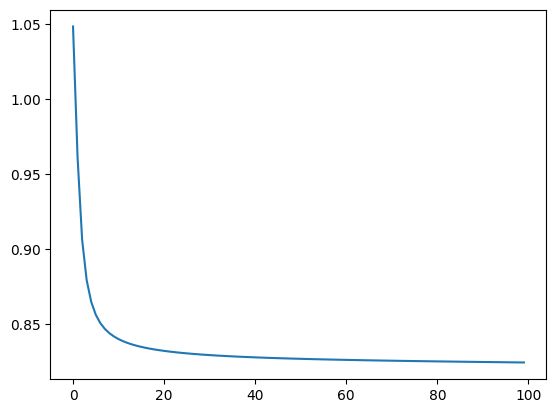

In [36]:
bow_ff_nn_predictions = []
original_lables_ff_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_500_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_500_padding_100_epochs.get_figure()
fig.savefig("ffnn_bow_loss_500_padding_100_epochs_less_lr.jpg")
